In [3]:
from importlib import reload
import time
import joblib
from pylab import *
from tqdm import tqdm


import sys
sys.path.append("..")

from helper_basic import *
import helper_basic as hp
import helper_finetime as hpt
import helper_visa as vs
reload(vs)
import config


In [4]:
path = config.scope
filename = config.scope+"coincidence_preamp_v5/2_short_long_bar.joblib"

data_save=joblib.load(filename)
time_series = data_save["metadata"]["time_series"]*1e9

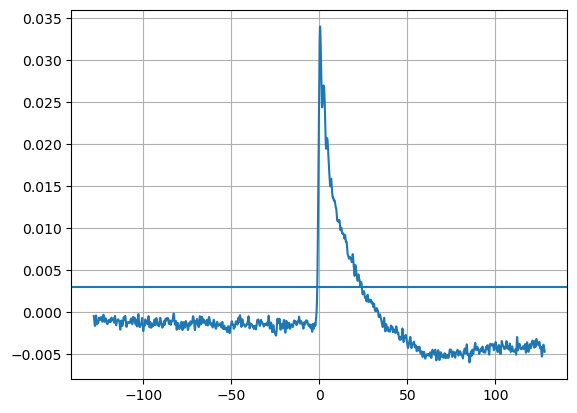

In [5]:
# Have a look at one pulse, and choose a trigger threshold
trigger_threshold_edge = 0.003

plot(time_series, data_save[1][3])
axhline(trigger_threshold_edge)

grid()

In [6]:
traces = data_save[2]
pre_trig = 1000
amplitude_cut=0.006*9

inds_keep, passage  = hp.cut_pulses(traces, cut_amp = None, cut_baseline="auto", cut_triggerpoint = False, cut_pileups= False, cut_iterations = 2, 
                                    pre_trig=pre_trig, threshold_in_sigma=6, gaussian_filter_sigma=2)

traces_processed = []
for i in inds_keep:
    trace = traces[i]
    trace -= np.mean(trace[:pre_trig])
    trigger_point = np.argmax(trace>trigger_threshold_edge)
    trace = np.roll(trace, -(trigger_point-2000))
    if max(trace)<amplitude_cut:
        continue
    traces_processed.append(trace)
    

32.10465474811054

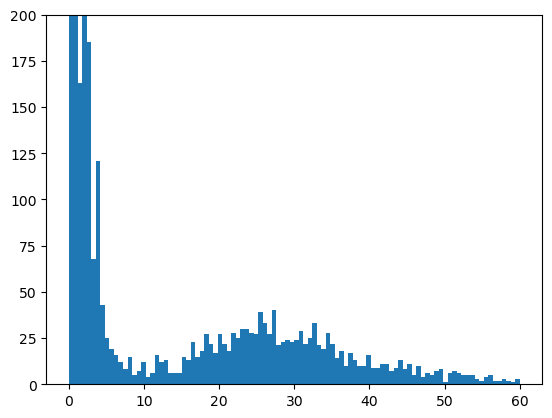

In [12]:
amp = np.array([max(t)*354.09330075501856 for t in traces])
hist(amp,range=(0,60), bins=100);
ylim(0,200)
np.mean(amp[amp>10])

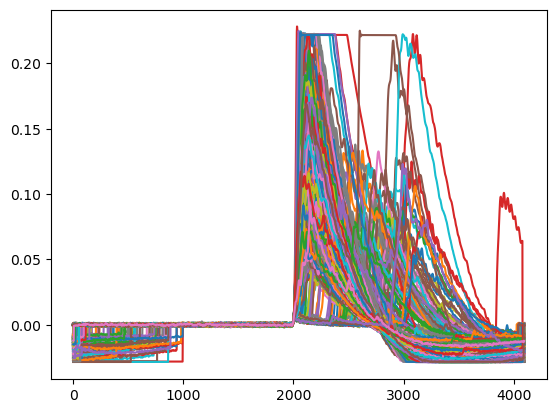

In [8]:
for t in traces_processed:
    plot(t)

/home/mathusla/tofpet/Mu-Hardware/SystemCharacterization/../helper_basic.py:57: RuntimeWarning: overflow encountered in exp
  pulse = (A1     *     (np.exp(-times[mask] / tau_f1))
/home/mathusla/tofpet/Mu-Hardware/SystemCharacterization/../helper_basic.py:62: RuntimeWarning: invalid value encountered in true_divide
  pulse/=max(pulse)
/home/mathusla/tofpet/Mu-Hardware/SystemCharacterization/../helper_basic.py:62: RuntimeWarning: divide by zero encountered in true_divide
  pulse/=max(pulse)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.

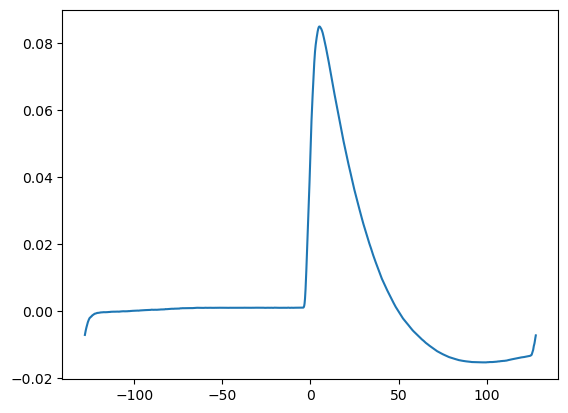

In [9]:
trace_original = traces_processed
trace_original_avg = np.mean(trace_original, axis=0)#*np.mean(trace_amps)
trace_original_avg-=np.mean(trace_original_avg[:1000])
# trace_original_avg/=max(trace_original_avg)



plot(time_series, trace_original_avg)

x=time_series
y=trace_original_avg
popt, pcov, info, f = hp.fit_curve(hp.Pulse2,x,y, fit_range=[-10,30],
                                    p0=[0.5,1,30,np.max(y)*0.5,np.max(y),x[np.argmax(y)],np.max(y)], maxfev=10000, makeplot=True)

# yscale("log")
# xlim(-2,30)
ylim(-0.01,)
grid(which="both")
xlabel("Time [ns]")
print(*popt, sep=",")

In [23]:
pulse_save = {"time_series_ns":time_series,
              "averaged_pulse_1pe_volt":trace_original_avg}
joblib.dump(pulse_save, os.path.splitext(filename)[0]+"_averaged.joblib")

import pickle

with open(os.path.splitext(filename)[0]+"_averaged.pkl", "wb") as f:
    pickle.dump(pulse_save, f)

(-10.0, 30.0)

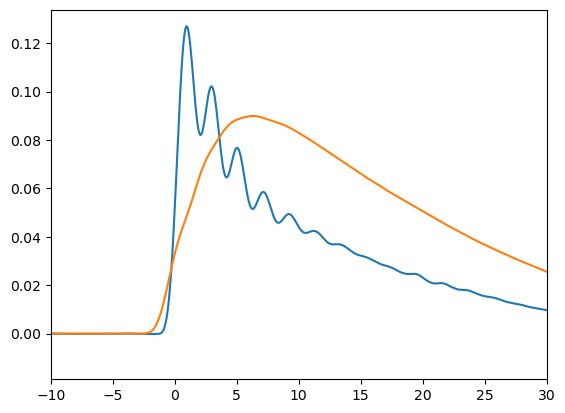

In [73]:
data=joblib.load("/mnt/sda2//scope_data/pulse_shape/preamp_v5_30pF_averaged.joblib",)
template_sipm = data["averaged_pulse_1pe_volt"]
# average_pulse/=max(average_pulse)
plot(data["time_series_ns"], template_sipm*20)
plot(time_series, trace_original_avg)


xlim(-10,30)

In [80]:
time_series_sipm = data["time_series_ns"]
tau_fiber = 1.9
tau_scintillator = 4

def make_scintillator_pulse(time_series, tau_fiber, tau_scintillator, amplitude=1, time_offset=0):
    # Set normed=0 to get a PDF
    time_distribution = hp.Pulse(t, 1, 0, tau_fiber, tau_scintillator, normed=0)
    # make this into [density per bin] by multiplying bin size:
    time_distribution = time_distribution * (time_series[1]-time_series[0])
    fake_trace = np.convolve(template_sipm,time_distribution, mode="same")
    fake_trace = fake_trace* amplitude
    fake_trace = scipy.ndimage.shift(fake_trace, -time_offset)
    return fake_trace

def least_square(args):
    tau_fit, amplitude, time_offset = args
    model_y = make_scintillator_pulse(time_series_sipm, tau_fiber, tau_fit, amplitude=amplitude, time_offset=time_offset)[1024:-1024]
    return np.sum((model_y-trace_original_avg)[100:-100]**2)

m = scipy.optimize.minimize(least_square, [3, 0.08, -2], method="Powell")

# tau_scan = np.linspace(2,8,10)
# chi2 = []
# for tau_scintillator in tau_scan:
#     fake_trace = make_scintillator_pulse(time_series_sipm, tau_fiber, tau_scintillator)
#     fake_trace *= max(trace_original_avg)
#     chi2.append(np.linalg.norm(fake_trace[1024:-1024] - trace_original_avg))
    

print(m.x)

[ 4.68317054 31.85790885 41.69281565]


[ 4.68317054 31.85790885 41.69281565]


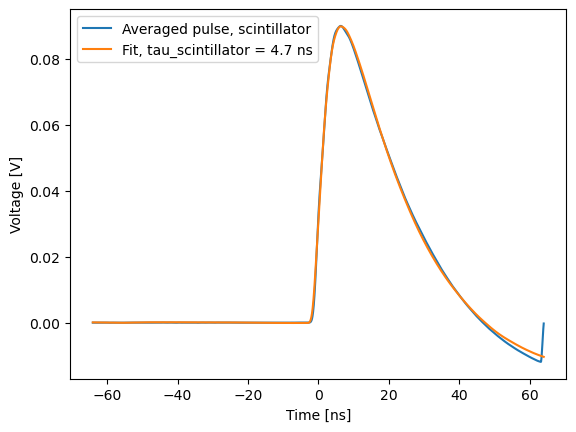

In [81]:
trace_fit = make_scintillator_pulse(time_series, tau_fiber, *m.x)
plot(time_series, trace_original_avg, label="Averaged pulse, scintillator")
plot(time_series, trace_fit[1024:-1024], label=f"Fit, tau_scintillator = {m.x[0]:.2} ns")
legend()
xlabel("Time [ns]")
ylabel("Voltage [V]")
print(m.x)
tau_scintillator_measured = m.x[2]

In [86]:
calib_coeff = m.x[1]/max(trace_original_avg)
integral_1pe = sum(template_sipm[data["time_series_ns"]<30])
amplitude_1pe = max(template_sipm)
print(calib_coeff, integral_1pe, amplitude_1pe)

354.09330075501856 0.97991216 0.006347436
